# Load libraries

In [32]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import os

import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import BatchNormalization
from keras.optimizers import SGD

In [2]:
# Use GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15533246439206590119
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3153041817
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6181866118649673911
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Load data

In [3]:
# Load mnist data
def load_data(data_directory):
    directories = [
        d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))
    ]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        print(f'reading {data_directory}\{d}')
        file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory)]
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

In [4]:
# read data locally
train_data_path = os.path.join(os.getcwd(),"data","training")
test_data_path = os.path.join(os.getcwd(),"data","testing")
images, labels = load_data(train_data_path)
test_images,test_labels = load_data(test_data_path)
x_train = np.asarray(images)
x_test = np.asarray(test_images)
y_train = np.asarray(labels)
y_test = np.asarray(test_labels)

reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\0
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\1
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\2
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\3
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\4
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\5
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\6
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\7
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\8
reading C:\Users\toanq\Work\rmit\ml_asm2\data\training\9
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\0
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\1
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\2
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\3
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\4
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\5
reading C:\Users\toanq\Work\rmit\ml_asm2\data\testing\6
reading C:\Users\toanq\Work\rmit\ml_as

# Preprocess data

In [5]:
# split training set to training and validating sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,random_state=0)

In [6]:
print(f'Train images: {x_train.shape}')
print(f'Train labels: {y_train.shape}')
print(f'Validation image: {x_val.shape}')
print(f'Validation labels: {y_val.shape}')
print(f'Test images: {x_test.shape}')
print(f'Test labels: {y_test.shape}')

Train images: (48000, 28, 28)
Train labels: (48000,)
Validation image: (12000, 28, 28)
Validation labels: (12000,)
Test images: (10000, 28, 28)
Test labels: (10000,)


In [7]:
# Preprocessing data

# Get number of pixels
num_pixels = x_train.shape[1] * x_train.shape[2]

# Set number of output classes
number_of_classes = 10

# convert labels to categorical one_hot encoder
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

# reshape images to 3D shape with 1 channel for color (this is to serve data augmentation later)
# divide all pixels by 255. to constrain input to 0-1 range
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.

# Create data generator (apply image augmentation)
train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                             height_shift_range=0.08, zoom_range=0.08)

# Create data generator for validation set
val_gen = ImageDataGenerator()

train_generator = train_gen.flow(x_train, y_train, batch_size=64)
val_generator = val_gen.flow(x_val, y_val, batch_size=64)

**Plot sample input image**

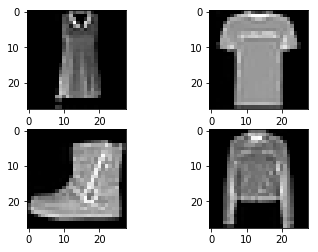

In [8]:
# Sample input
plt.subplot(221)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.subplot(222)
plt.imshow(x_train[1].reshape(28, 28), cmap='gray')
plt.subplot(223)
plt.imshow(x_train[2].reshape(28, 28), cmap='gray')
plt.subplot(224)
plt.imshow(x_train[3].reshape(28, 28), cmap='gray')
plt.show()

# Build model and train

## Vanilla model
(No regularization layer such as Batch Normalization or Dropout)

### Build model

In [9]:
# Build model
model_vanilla = Sequential()

# Flatten the input to 1D array (784,)
model_vanilla.add(Flatten(input_shape=(28, 28, 1)))

# Add 1st layer, randomly dropping 50% nodes during training
model_vanilla.add(Dense(1024))
model_vanilla.add(Activation('relu'))

# add output layer
model_vanilla.add(Dense(number_of_classes, activation='softmax'))

# compile model
model_vanilla.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print summary of model
model_vanilla.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________


### Train model

In [13]:
# train model
H_vanilla = model_vanilla.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=50, 
                                        validation_data=val_generator, validation_steps=10000//64)

Epoch 1/3
937/937 [==============================] - 29s 31ms/step - loss: 0.4942 - acc: 0.8133 - val_loss: 0.4193 - val_acc: 0.8402
Epoch 2/3
937/937 [==============================] - 29s 30ms/step - loss: 0.4740 - acc: 0.8228 - val_loss: 0.3929 - val_acc: 0.8571
Epoch 3/3
937/937 [==============================] - 28s 30ms/step - loss: 0.4553 - acc: 0.8303 - val_loss: 0.3895 - val_acc: 0.8557


### Plot model performance

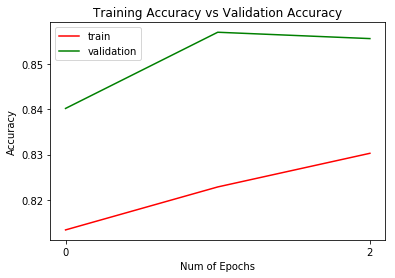

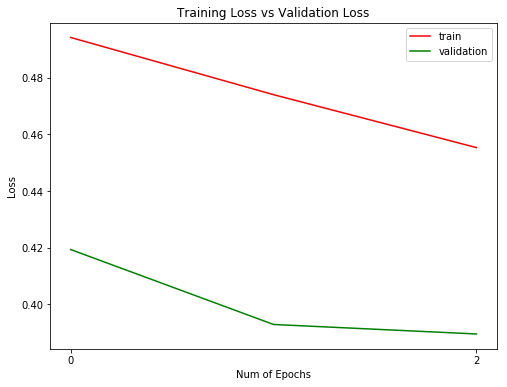

In [14]:
# Get model performance
training_accuracy = H_vanilla.history['acc']
validation_accuracy = H_vanilla.history['val_acc']
training_error = H_vanilla.history['loss']
validation_error = H_vanilla.history['val_loss']

# Plot performance
plt.figure(0)
plt.plot(training_accuracy,'r')
plt.plot(validation_accuracy,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
plt.figure(1)
plt.plot(training_error,'r')
plt.plot(validation_error,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### Test model performance on test set

In [37]:
scores = model_vanilla.evaluate(x_test, y_test, verbose=0)
print("MLP Error on test set: %.2f%%" % (100-scores[1]*100))
print("MLP Accuracy on test set: %.2f%%" % (scores[1]*100))

print('\nClassification report:')
predict_test = model_vanilla.predict(x_test)
print(classification_report(y_test.argmax(axis=1), predict_test.argmax(axis=1)))

MLP Error on test set: 14.80%
MLP Accuracy on test set: 85.20%

Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.98      0.97      0.97      1000
           2       0.73      0.74      0.73      1000
           3       0.87      0.84      0.86      1000
           4       0.73      0.72      0.73      1000
           5       0.97      0.94      0.96      1000
           6       0.62      0.63      0.62      1000
           7       0.95      0.92      0.93      1000
           8       0.97      0.96      0.97      1000
           9       0.91      0.97      0.94      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Model with Drop out

### Build model

In [16]:
# Build model
model_dropout = Sequential()

# Flatten the input to 1D array (784,)
model_dropout.add(Flatten(input_shape=(28, 28, 1)))

# Add 1st layer, randomly dropping 50% nodes during training
model_dropout.add(Dense(1024))
model_dropout.add(Dropout(0.5))
model_dropout.add(Activation('relu'))

# add output layer
model_dropout.add(Dense(number_of_classes, activation='softmax'))

# compile model
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print summary of model
model_dropout.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________


### Train model

In [17]:
# train model
H_dropout = model_dropout.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=50, 
                                        validation_data=val_generator, validation_steps=10000//64)

Epoch 1/3
937/937 [==============================] - 30s 32ms/step - loss: 0.7692 - acc: 0.7111 - val_loss: 0.5489 - val_acc: 0.7996
Epoch 2/3
937/937 [==============================] - 30s 32ms/step - loss: 0.6383 - acc: 0.7578 - val_loss: 0.4979 - val_acc: 0.8195
Epoch 3/3
937/937 [==============================] - 29s 31ms/step - loss: 0.6000 - acc: 0.7746 - val_loss: 0.4762 - val_acc: 0.8184


### Plot model performance

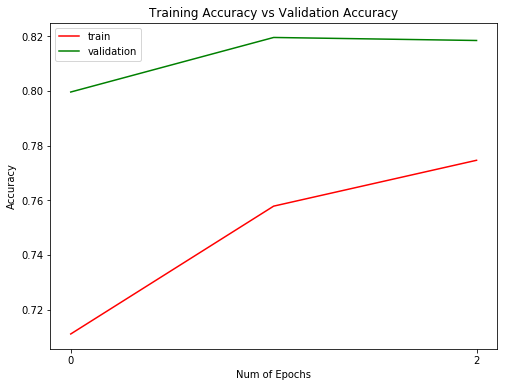

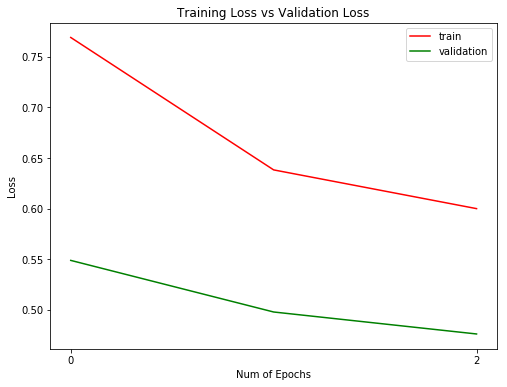

In [18]:
# Get model performance
training_accuracy = H_dropout.history['acc']
validation_accuracy = H_dropout.history['val_acc']
training_error = H_dropout.history['loss']
validation_error = H_dropout.history['val_loss']

# Plot performance
plt.figure(0)
plt.plot(training_accuracy,'r')
plt.plot(validation_accuracy,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
plt.figure(1)
plt.plot(training_error,'r')
plt.plot(validation_error,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### Test model performance on test set

In [39]:
scores = model_dropout.evaluate(x_test, y_test, verbose=0)
print("MLP Error on test set: %.2f%%" % (100-scores[1]*100))
print("MLP Accuracy on test set: %.2f%%" % (scores[1]*100))

print('\nClassification report:')
predict_test = model_dropout.predict(x_test)
print(classification_report(y_test.argmax(axis=1), predict_test.argmax(axis=1)))

MLP Error on test set: 18.56%
MLP Accuracy on test set: 81.44%

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1000
           1       0.96      0.96      0.96      1000
           2       0.60      0.82      0.69      1000
           3       0.79      0.77      0.78      1000
           4       0.66      0.73      0.70      1000
           5       0.96      0.92      0.94      1000
           6       0.67      0.33      0.44      1000
           7       0.92      0.91      0.91      1000
           8       0.95      0.95      0.95      1000
           9       0.91      0.97      0.94      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



## Model with Batch Normalization - Adam optimizer

### Build model

In [21]:
# Build model

model_bn = Sequential()

# Flatten the input to 1D array (784,)
model_bn.add(Flatten(input_shape=(28, 28, 1)))

# Normalize input
model_bn.add(BatchNormalization())

# Add 1st layer, using BatchNormalization to normalize output
model_bn.add(Dense(32))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))

model_bn.add(Dense(32))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))

model_bn.add(Dense(16))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))

# Add output layer
model_bn.add(Dense(number_of_classes, activation='softmax'))

model_bn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
__________

### Train model

In [23]:
# fit model
H_bn = model_bn.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=30, 
                        validation_data=val_generator, validation_steps=10000//64)

Epoch 1/3
937/937 [==============================] - 32s 34ms/step - loss: 0.8822 - acc: 0.7051 - val_loss: 0.5542 - val_acc: 0.7949
Epoch 2/3
937/937 [==============================] - 30s 32ms/step - loss: 0.6304 - acc: 0.7677 - val_loss: 0.5084 - val_acc: 0.8090
Epoch 3/3
937/937 [==============================] - 30s 32ms/step - loss: 0.5923 - acc: 0.7800 - val_loss: 0.4833 - val_acc: 0.8101


### Plot model performance

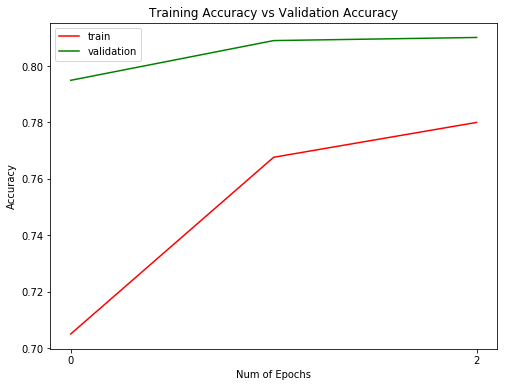

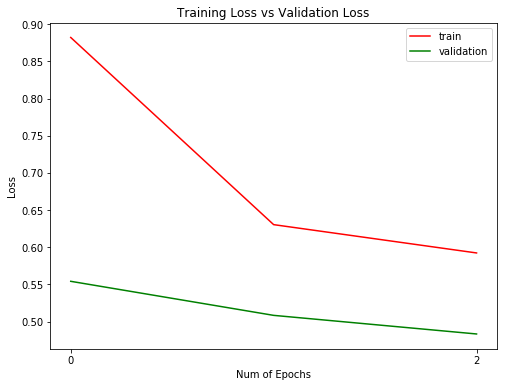

In [24]:
# Get performance from model
training_accuracy = H_bn.history['acc']
validation_accuracy = H_bn.history['val_acc']
training_error = H_bn.history['loss']
validation_error = H_bn.history['val_loss']

# Plot performance
plt.figure(0)
plt.plot(training_accuracy,'r')
plt.plot(validation_accuracy,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
plt.figure(1)
plt.plot(training_error,'r')
plt.plot(validation_error,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### Test model performance on test set

In [40]:
scores = model_bn.evaluate(x_test, y_test, verbose=0)
print("MLP Error on test set: %.2f%%" % (100-scores[1]*100))
print("MLP Accuracy on test set: %.2f%%" % (scores[1]*100))

print('\nClassification report:')
predict_test = model_bn.predict(x_test)
print(classification_report(y_test.argmax(axis=1), predict_test.argmax(axis=1)))

MLP Error on test set: 18.86%
MLP Accuracy on test set: 81.14%

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1000
           1       0.96      0.95      0.95      1000
           2       0.75      0.52      0.61      1000
           3       0.79      0.86      0.83      1000
           4       0.65      0.80      0.72      1000
           5       0.89      0.92      0.91      1000
           6       0.54      0.51      0.53      1000
           7       0.93      0.87      0.90      1000
           8       0.96      0.93      0.95      1000
           9       0.90      0.95      0.92      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



## Model with Batch Normalization - Stochastic Gradient Descent and learning rate decay

### Build model

In [28]:
# Build model
model_sgd = Sequential()

# Flatten the input to 1D array (784,)
model_sgd.add(Flatten(input_shape=(28, 28, 1)))

# Normalize input
model_sgd.add(BatchNormalization())

# Add 1st layer, using BatchNormalization to normalize output
model_sgd.add(Dense(128))
model_sgd.add(BatchNormalization())
model_sgd.add(Activation('relu'))

model_sgd.add(Dense(128))
model_sgd.add(BatchNormalization())
model_sgd.add(Activation('relu'))

# Add output layer
model_sgd.add(Dense(number_of_classes, activation='softmax'))

# optimizer
NUM_EPOCHS = 25
INIT_LR = 1e-2
opt = tSGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)

model_sgd.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 784)               3136      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               100480    
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
__________

### Train model

In [29]:
# fit model
H_sgd = model_sgd.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=NUM_EPOCHS, 
                            validation_data=val_generator, validation_steps=10000//64)

Epoch 1/3
937/937 [==============================] - 33s 35ms/step - loss: 0.6851 - acc: 0.7467 - val_loss: 0.4961 - val_acc: 0.8157
Epoch 2/3
937/937 [==============================] - 31s 33ms/step - loss: 0.5706 - acc: 0.7866 - val_loss: 0.4687 - val_acc: 0.8281
Epoch 3/3
937/937 [==============================] - 30s 32ms/step - loss: 0.5499 - acc: 0.7951 - val_loss: 0.4606 - val_acc: 0.8274


### Plot model performance

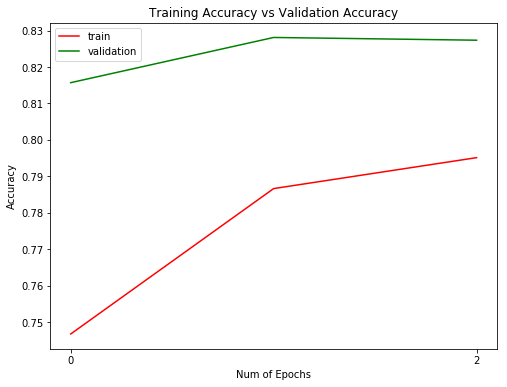

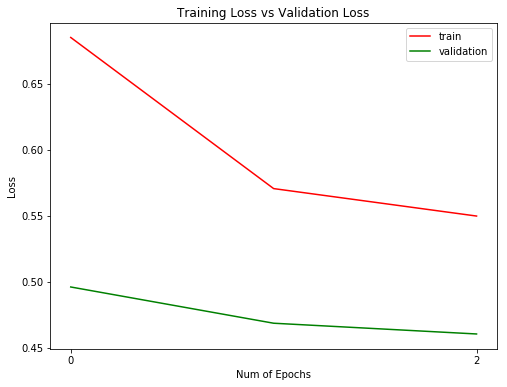

In [30]:
# Get performance from model
training_accuracy = H_sgd.history['acc']
validation_accuracy = H_sgd.history['val_acc']
training_error = H_sgd.history['loss']
validation_error = H_sgd.history['val_loss']

# Plot model performance
plt.figure(0)
plt.plot(training_accuracy,'r')
plt.plot(validation_accuracy,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
plt.figure(1)
plt.plot(training_error,'r')
plt.plot(validation_error,'g')
plt.xticks(np.arange(0, len(training_accuracy), 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

### Test model performance on test set

In [42]:
scores = model_sgd.evaluate(x_test, y_test, verbose=0)
print("MLP Error on test set: %.2f%%" % (100-scores[1]*100))
print("MLP Accuracy on test set: %.2f%%" % (scores[1]*100))

print('\nClassification report:')
predict_test = model_sgd.predict(x_test)
print(classification_report(y_test.argmax(axis=1), predict_test.argmax(axis=1)))

MLP Error on test set: 17.53%
MLP Accuracy on test set: 82.47%

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1000
           1       0.98      0.94      0.96      1000
           2       0.66      0.73      0.70      1000
           3       0.80      0.86      0.83      1000
           4       0.77      0.64      0.69      1000
           5       0.92      0.93      0.93      1000
           6       0.54      0.56      0.55      1000
           7       0.91      0.92      0.91      1000
           8       0.96      0.94      0.95      1000
           9       0.93      0.93      0.93      1000

   micro avg       0.82      0.82      0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



# Summary

*Several classes has high precision and recall score, while some has low*